### Import libraries

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, classification_report,confusion_matrix


### Read Data

In [2]:
col_type={'uuid':str,
                        'default':float,
                        'account_amount_added_12_24m':float,
                        'numericaccount_days_in_dc_12_24m':float,
                        'account_days_in_rem_12_24m':float,
                        'account_days_in_term_12_24m':float,
                        'account_incoming_debt_vs_paid_0_24m':float,
                        'account_status':str,
                        'account_worst_status_0_3m':str,
                        'account_worst_status_12_24m':str,
                        'account_worst_status_3_6m':str,
                        'account_worst_status_6_12m':str,
                        'age':float,
                        'avg_payment_span_0_12m':float,
                        'avg_payment_span_0_3m':float,
                        'merchant_category':str,
                        'merchant_group':str,
                        'has_paid':int,
                        'max_paid_inv_0_12m':float,
                        'max_paid_inv_0_24m':float,
                        'name_in_email':str,
                        'num_active_div_by_paid_inv_0_12m':float,
                        'num_active_inv':float,
                        'num_arch_dc_0_12m':float,
                        'num_arch_dc_12_24m':float,
                        'num_arch_ok_0_12m':float,
                        'num_arch_ok_12_24m':float,
                        'num_arch_rem_0_12m':float,
                        'num_arch_written_off_0_12m':float,
                        'num_arch_written_off_12_24m':float,
                        'num_unpaid_bills':float,
                        'status_last_archived_0_24m':str,
                        'status_2nd_last_archived_0_24m':str,
                        'status_3rd_last_archived_0_24m':str,
                        'status_max_archived_0_6_months':str,
                        'status_max_archived_0_12_months':str,
                        'status_max_archived_0_24_months':str,
                        'recovery_debt':float,
                        'sum_capital_paid_account_0_12m':float,
                        'sum_capital_paid_account_12_24m':float,
                        'sum_paid_inv_0_12m':float,
                        'time_hours':float,
                        'worst_status_active_inv':str,
                    }


df_all=pd.read_csv('dataset.csv', 
               delimiter=';', 
#                    dtype=col_type
                  )


In [3]:
df_all.head(2)

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN


In [4]:
#if default is na, then it needs to be predicted

df_test=df_all[df_all.default.isna()]
df=df_all[df_all.default.isna()==0]

### EDA

In [5]:
# to look at variables at a glance

# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file("your_report.html")

In [6]:
# to check if missingness has predictive power

for col in df.columns:
    if df[col].isna().sum()>0:
        print(df.groupby(df[col].map(lambda x: 'missing' if x!=x else 'not-missing')).default.mean())

account_days_in_dc_12_24m
missing        0.008518
not-missing    0.015096
Name: default, dtype: float64
account_days_in_rem_12_24m
missing        0.008518
not-missing    0.015096
Name: default, dtype: float64
account_days_in_term_12_24m
missing        0.008518
not-missing    0.015096
Name: default, dtype: float64
account_incoming_debt_vs_paid_0_24m
missing        0.010758
not-missing    0.019498
Name: default, dtype: float64
account_status
missing        0.009237
not-missing    0.020369
Name: default, dtype: float64
account_worst_status_0_3m
missing        0.009237
not-missing    0.020369
Name: default, dtype: float64
account_worst_status_12_24m
missing        0.012455
not-missing    0.018048
Name: default, dtype: float64
account_worst_status_3_6m
missing        0.010975
not-missing    0.018876
Name: default, dtype: float64
account_worst_status_6_12m
missing        0.011636
not-missing    0.018394
Name: default, dtype: float64
avg_payment_span_0_12m
missing        0.028787
not-missing 

#### Clearly, missingness corresponds to higher defaults in most features. Therefore, instead of treating with any mean or median, I replace null values with -1.

In [7]:
#check if default is affected by categories:
for col in col_type:
    if(col_type[col]==str):
        print(df.groupby(col).default.mean())

uuid
0000452c-0a2e-41ce-ba63-3c4c0ced3921    0.0
0000f71d-c416-4307-a309-212ca4104089    0.0
00013f58-9c3a-4801-ab36-725a78c702b8    0.0
000236b0-9873-4ad3-ac4f-e249a3c26f79    0.0
0002605e-7d2c-460e-b504-6aa3616ce008    0.0
                                       ... 
fffaa3ac-1b5a-41ba-a9c1-c3498e6c9408    0.0
fffc9e54-407c-4f50-a997-79f26f103161    0.0
fffcabdc-4a59-4ce6-8ce5-0f75762f651e    0.0
ffff18d1-cb07-4975-a001-e15b48fcece0    0.0
ffffd626-bfbd-407e-a611-ad838b6b1248    0.0
Name: default, Length: 89976, dtype: float64
account_status
1.0    0.016978
2.0    0.096621
3.0    0.285714
4.0    1.000000
Name: default, dtype: float64
account_worst_status_0_3m
1.0    0.011760
2.0    0.058120
3.0    0.143216
4.0    0.234694
Name: default, dtype: float64
account_worst_status_12_24m
1.0    0.007757
2.0    0.032849
3.0    0.088398
4.0    0.193133
Name: default, dtype: float64
account_worst_status_3_6m
1.0    0.011196
2.0    0.048092
3.0    0.098253
4.0    0.315789
Name: default, dtype: flo

#### Almost in all string columns which are already enocded as integers, higher number corresponds to higher defaults. Since this increases in one direction, I consider the columns as continuous, and not categorical. 

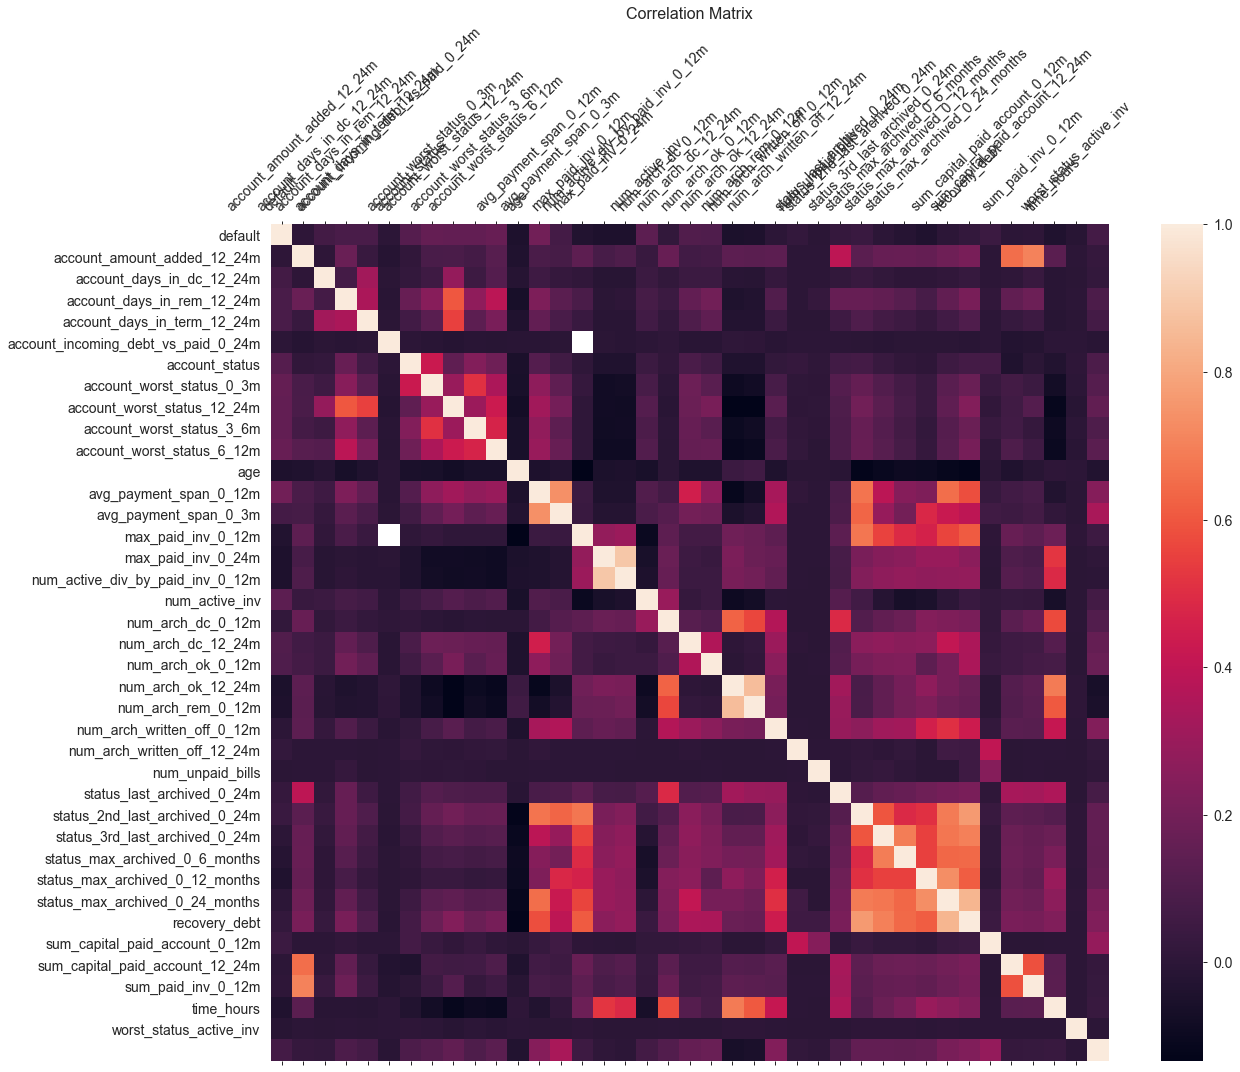

In [8]:
# check for correlation among features

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

#### Not much correlation whatsoever..

### Prepare Data

In [9]:
# since the mean of default varies according to missingnes, it may be useful to not remove null values

df.fillna(-1, inplace=True)

C:\Users\nishant\anaconda3\lib\site-packages\pandas\core\frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [10]:
# train test split

df_train,df_val,y_train,y_val=train_test_split(df.iloc[:,2:],df.iloc[:,1], test_size=.2, stratify=df.default)

In [11]:
y_val.sum()

258.0

In [12]:
def preprocess(df_here,target, enc=None, transform_type='training'):
  
#     for col in df_train.columns:
#         print(col)
#         if df_train[col].isna().sum()/df_train[col].count()>0.2:
#             df_here[col]=df_here[col].map(lambda x:0 if x else 1)

#         else:
#             if col not in df.select_dtypes(['object']).columns:
#                 imp=SimpleImputer(strategy='mean').fit(df_train[[col]])
#                 df_here[col]=imp.transform(df_here[[col]])
#             else:
#                 imp=SimpleImputer(strategy='most_frequent').fit(df_train[[col]])
#                 df_here[col]=imp.transform(df_here[[col]])

    if transform_type=='training':
        enc=TargetEncoder(min_samples_leaf=5, smoothing=1.0)
        enc.fit(df_here,y_train)
        df_here=enc.transform(df_here)
    else:
        df_here=enc.transform(df_here)
        
    return df_here, enc

In [13]:
# PREPROCESS FEATURE SETS
X_train,encoder=preprocess(df_train.copy(),y_train.copy(),transform_type='training')
X_val,_=preprocess(df_val.copy(),None,encoder,transform_type='testing')

C:\Users\nishant\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Feature Scaling

In [14]:
# from sklearn.preprocessing import StandardScaler
# scl=StandardScaler().fit(X_train)
# X_train=scl.transform(X_train)
# X_test=scl.transform(X_val)

### Handle Class Imbalance

In [15]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True,sampling_strategy =0.02)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X_train, y_train)


from collections import Counter
print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0.0: 70950, 1.0: 1030})
Resample dataset shape Counter({0.0: 51500, 1.0: 1030})


In [16]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy =0.1)

# fit predictor and target variable
x_ros, y_ros = smote.fit_resample(x_rus, y_rus)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0.0: 70950, 1.0: 1030})
Resample dataset shape Counter({0.0: 51500, 1.0: 5150})


### Evaluation

In [17]:
# model performance

def report(clf):
    pred=clf.predict(X_val)
    print('\nclassification report')
    print(classification_report(y_val,pred))
    print('accuracy:',sum(y_val==pred)/len(y_val))
    print('logloss:',log_loss(y_val,pred))
    print('\nconfusion matrix')
    print(confusion_matrix(y_val,pred))

In [18]:
#Random guessing log-loss

def calculate_log_loss(class_ratio,multi=10000):
    
    if sum(class_ratio)!=1.0:
        print("warning: Sum of ratios should be 1 for best results")
        class_ratio[-1]+=1-sum(class_ratio)  # add the residual to last class's ratio
    
    actuals=[]
    for i,val in enumerate(class_ratio):
        actuals=actuals+[i for x in range(int(val*multi))]
        

    preds=[]
    for i in range(multi):
        preds+=[class_ratio]

    return (log_loss(actuals, preds))

logloss=calculate_log_loss([.986,.014],multi=1000)
logloss

#this is when we have perfect classification for this dataset

0.07366331072932493

### Training

In [19]:
clf1=CatBoostClassifier(iterations=100, max_depth=12,loss_function='Logloss',
#                        cat_features=df_train.select_dtypes('object').columns,
                       task_type="GPU",devices='0:1',
#                        class_weights=[10, 1]
               
                      )
clf1.fit(x_ros, y_ros,plot=False,eval_set=(X_val,y_val),verbose=False)
report(clf1)


classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17738
         1.0       0.55      0.10      0.18       258

    accuracy                           0.99     17996
   macro avg       0.77      0.55      0.58     17996
weighted avg       0.98      0.99      0.98     17996

accuracy: 0.9859413202933985
logloss: 0.4855705722969484

confusion matrix
[[17716    22]
 [  231    27]]


In [20]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(max_depth=10, random_state=0)
clf2.fit(x_ros, y_ros)
report(clf2)


classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17738
         1.0       0.43      0.08      0.13       258

    accuracy                           0.99     17996
   macro avg       0.71      0.54      0.56     17996
weighted avg       0.98      0.99      0.98     17996

accuracy: 0.9853300733496333
logloss: 0.506682471537543

confusion matrix
[[17712    26]
 [  238    20]]


In [21]:
from lightgbm import LGBMClassifier
clf3 = LGBMClassifier(max_depth=10, random_state=0)
clf3.fit(x_ros, y_ros)
report(clf3)


classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17738
         1.0       0.48      0.12      0.19       258

    accuracy                           0.99     17996
   macro avg       0.73      0.56      0.59     17996
weighted avg       0.98      0.99      0.98     17996

accuracy: 0.9854967770615692
logloss: 0.5009250403304569

confusion matrix
[[17705    33]
 [  228    30]]


In [22]:
from sklearn.tree import DecisionTreeClassifier
clf4 = DecisionTreeClassifier(max_depth=12)
clf4.fit(x_ros,y_ros)
report(clf4)


classification report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     17738
         1.0       0.17      0.13      0.15       258

    accuracy                           0.98     17996
   macro avg       0.58      0.56      0.57     17996
weighted avg       0.98      0.98      0.98     17996

accuracy: 0.9788286285841298
logloss: 0.7312401946910478

confusion matrix
[[17582   156]
 [  225    33]]


In [23]:
# from sklearn import svm
# clf5 = svm.SVC()
# clf5.fit(x_ros,y_ros)
# report(clf5)

In [24]:
from sklearn.linear_model import LogisticRegression
clf6 = LogisticRegression()
clf6.fit(x_ros,y_ros)
report(clf6)


classification report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     17738
         1.0       0.16      0.12      0.14       258

    accuracy                           0.98     17996
   macro avg       0.58      0.55      0.56     17996
weighted avg       0.98      0.98      0.98     17996

accuracy: 0.9788841964881084
logloss: 0.729320769552982

confusion matrix
[[17586   152]
 [  228    30]]


C:\Users\nishant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Voting

In [25]:
#Adding predictions from all classifiers

final_pred_sum_val=clf1.predict_proba(X_val)[:,1]+\
                clf2.predict_proba(X_val)[:,1]+\
                clf3.predict_proba(X_val)[:,1]+\
                clf4.predict_proba(X_val)[:,1]+\
                clf6.predict_proba(X_val)[:,1]

final_pred_sum=clf1.predict_proba(X_train)[:,1]+\
                clf2.predict_proba(X_train)[:,1]+\
                clf3.predict_proba(X_train)[:,1]+\
                clf4.predict_proba(X_train)[:,1]+\
                clf6.predict_proba(X_train)[:,1]
                
#Taking mean of all probabilities and then deciding the result

final_pred_val=pd.Series(final_pred_sum_val).map(lambda x:1 if x/5>=0.5 else 0).values

final_pred=pd.Series(final_pred_sum).map(lambda x:1 if x/5>=0.5 else 0).values


In [26]:
pd.Series(final_pred).value_counts()

0    71483
1      497
dtype: int64

### Results

In [27]:
#Validation
print('\nclassification report')
print(classification_report(y_val,final_pred_val))
print('accuracy:',sum(y_val==final_pred_val)/len(y_val))
print('logloss:',log_loss(y_val,final_pred_val))
print('\nconfusion matrix')
print(confusion_matrix(y_val,final_pred_val))


classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17738
         1.0       0.43      0.08      0.14       258

    accuracy                           0.99     17996
   macro avg       0.71      0.54      0.56     17996
weighted avg       0.98      0.99      0.98     17996

accuracy: 0.9852745054456545
logloss: 0.5086018078117022

confusion matrix
[[17710    28]
 [  237    21]]


In [28]:
#Train
print('\nclassification report')
print(classification_report(y_train,final_pred))
print('accuracy:',sum(y_train==final_pred)/len(y_train))
print('logloss:',log_loss(y_train,final_pred))
print('\nconfusion matrix')
print(confusion_matrix(y_train,final_pred))


classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     70950
         1.0       0.83      0.40      0.54      1030

    accuracy                           0.99     71980
   macro avg       0.91      0.70      0.77     71980
weighted avg       0.99      0.99      0.99     71980

accuracy: 0.9902611836621283
logloss: 0.3363677329677215

confusion matrix
[[70866    84]
 [  617   413]]


## For test data

In [97]:
df_test.shape

(10000, 43)

In [98]:
df_test.fillna(-1, inplace=True)
X_test,_=preprocess(df_test.iloc[:,2:],None,encoder,transform_type='testing')

final_pred_sum=clf1.predict_proba(X_test)[:,1]+\
                clf2.predict_proba(X_test)[:,1]+\
                clf3.predict_proba(X_test)[:,1]+\
                clf4.predict_proba(X_test)[:,1]+\
                clf6.predict_proba(X_test)[:,1]
                
#Taking mean of all probabilities and then deciding the result

final_pred=pd.Series(final_pred_sum).map(lambda x:1 if x/5>=0.5 else 0).values

C:\Users\nishant\anaconda3\lib\site-packages\pandas\core\frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


### Export results

In [104]:
results=df_test.iloc[:,:1]

In [105]:
results['pd']=final_pred

C:\Users\nishant\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
results.to_csv('results.csv',index=False,sep=';')

### Pickle the model and encoder to use for real data

In [111]:
import pickle
pickle.dump(clf1, open('model1.pkl','wb'))
pickle.dump(clf2, open('model2.pkl','wb'))
pickle.dump(clf3, open('model3.pkl','wb'))
pickle.dump(clf4, open('model4.pkl','wb'))
pickle.dump(clf6, open('model5.pkl','wb'))

pickle.dump(encoder, open('encoder.pkl','wb'))